In [1]:
import pandas as pd
import numpy as np

options_df = pd.read_csv("options_cleaned.csv")

# options_df.sample(frac=1, random_state=43)
full_options_df = pd.read_csv("options_withriskfreerates_andDeltaT.csv")

Need to prepare the train, validation/dev and test sets. In this first trial, I will use a 70%/20%/10% split

I will also perform this split individually for each stock ticker, in order to have equal portions from each stock ticker

In [2]:
tickers = ["AAPL","NVDA","TSLA","AMD","AMZN","MSFT","META","SPY"]

train_list = []
dev_list = []
test_list = []

for ticker in tickers:

    df = options_df[full_options_df["stockTicker"] == ticker]

    train, dev, test = np.split(df.sample(frac=1,random_state=42), 
                       [int(0.7*len(df)), int(.9*len(df))])
    
    train_list.append(train)
    dev_list.append(dev)
    test_list.append(test)

train_df = pd.concat(train_list, ignore_index=True)
dev_df = pd.concat(dev_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

target_col = "lastPrice"

Y_train = train_df[[target_col]]
X_train = train_df.drop(columns=[target_col])

Y_dev = dev_df[[target_col]]
X_dev = dev_df.drop(columns=[target_col])

Y_test = test_df[[target_col]]
X_test = test_df.drop(columns=[target_col])


C:\Users\saiha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

In [4]:
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

In [5]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)  

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [6]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_dev, Y_dev),
    epochs=100,              # Start with a small number, like 50
    batch_size=32,          # Common choice
    verbose=1               # Shows progress per epoch
)

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'
Epoch 1/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 260231.8438 - mae: 98.5948 - val_loss: 12581.5566 - val_mae: 67.4360
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 24915.9883 - mae: 71.3721 - val_loss: 28224.6055 - val_mae: 77.3034
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 41376.5859 - mae: 76.0322 - val_loss: 11755.7109 - val_mae: 66.0819
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 12305.9287 - mae: 66.4401 - val_loss: 11338.2383 - val_mae: 66.0957
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 24699.3594 - mae: 67.2912 - val_loss: 25657.2988 - val_mae: 76.3230
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15609.7539 - mae: 67.1278 - val_loss: 10519.0039 - val_mae: 60.9594
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10689.2119 - mae: 60.8965 - val_loss: 10130.7178 - val_mae: 59.6834
Epoch 8/100
636/636 ━━━━━━━━

In [7]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [8]:
model.optimizer.learning_rate.numpy()

np.float32(0.0005)

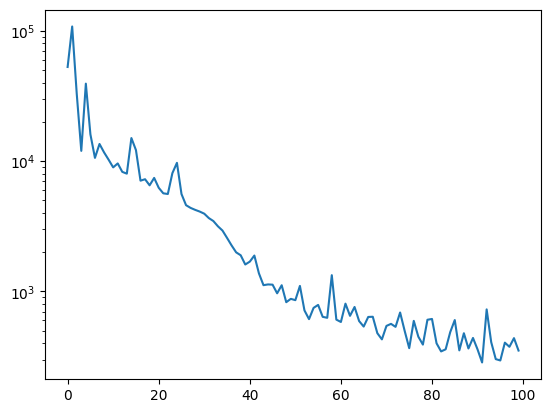

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.yscale("log")

In [19]:
history.history["mae"][-1],history.history["val_mae"][-1]

(13.507769584655762, 13.244246482849121)

In [4]:
from models import BlackScholesModel

In [5]:
stock_price = options_df["stockClosePrice"]
strike_price = options_df["strike"]
riskfree_rate = options_df["riskfree_rate"]
time_to_expiry = options_df["deltaT_years"]
volatility = options_df["impliedVolatility"]
isCall = options_df["isCall"]

price_BS = np.zeros_like(stock_price)

for i in range(len(options_df)):
    price_BS[i] = BlackScholesModel(stock_price[i],strike_price[i],riskfree_rate[i],time_to_expiry[i],volatility[i],isCall[i])

In [7]:
mae_BS = np.mean(np.abs(price_BS - options_df["lastPrice"]))

mae_BS

np.float64(29.591169294508173)

In [10]:
options_df["lastPrice"].mean(), options_df["lastPrice"].std()

(np.float64(80.99049724896837), np.float64(135.43975112824418))

In [10]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers

def build_model(hp):
    model = keras.Sequential()

    # Tune number of layers (1 to 3)
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=256, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"])
            )
        )
    
    model.add(layers.Dense(1, activation='linear'))  # output layer for regression

    # Tune optimizer
    optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=getattr(keras.optimizers, optimizer.capitalize())(learning_rate=learning_rate),
        loss="mae",
        metrics=["mae"]
    )

    return model


In [11]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_mae",
    max_trials=10,              # Try 10 different hyperparameter combinations
    executions_per_trial=1,     # How many times to train each model
    directory="kt_tuner",
    project_name="option_price_model"
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    X_train, Y_train,
    validation_data=(X_dev, Y_dev),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Trial 10 Complete [00h 00m 00s]

Best val_mae So Far: 7.587751388549805
Total elapsed time: 00h 09m 51s


In [13]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

# Evaluate the best model
test_loss, test_mae = best_model.evaluate(X_test, Y_test)
print("Test MAE:", test_mae)

C:\Users\saiha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters:
num_layers: 3
units_0: 32
activation: relu
optimizer: adam
learning_rate: 0.0009388837297496945
units_1: 128
units_2: 64
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.1134 - mae: 9.1134
Test MAE: 7.897063255310059


After tuning and finding the best hyperparameters:

In [18]:
best_model.save("best_model_from_tuner.keras")

In [14]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Explicit Input layer
    Dense(32, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)  # Regression output
])

In [15]:
optimizer = Adam(learning_rate=0.0009)  

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

In [16]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_dev, Y_dev),
    epochs=100,              # Start with a small number, like 50
    batch_size=32,          # Common choice
    verbose=1               # Shows progress per epoch
)

Epoch 1/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 615095.3125 - mae: 116.2965 - val_loss: 13190.6465 - val_mae: 66.7566
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 20778.9297 - mae: 73.5029 - val_loss: 76294.9453 - val_mae: 98.9629
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 136885.0156 - mae: 100.3196 - val_loss: 134987.7969 - val_mae: 85.0524
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 67029.1797 - mae: 75.9677 - val_loss: 10494.1992 - val_mae: 60.0727
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10804.7178 - mae: 60.9958 - val_loss: 10243.0771 - val_mae: 58.1748
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9927.2949 - mae: 58.2135 - val_loss: 11196.7197 - val_mae: 61.5780
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 10434.8291 - mae: 57.3179 - val_loss: 10497.3867 - val_mae: 54.5468
Epoch 8/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9806.0654 - mae: 55.3277 - val_l

In [23]:
# pd.concat([X_test,Y_test])
X_test
# Y_test

,strike,stockClosePrice,deltaT_years,riskfree_rate,isCall,volume,openInterest,impliedVolatility,inTheMoney,isNVDA
0,175.0,211.160004,0.690819,0.0437,0,1.0,8311.0,0.286323,False,0
1,170.0,211.160004,0.191854,0.0437,0,636.0,10702.0,0.334968,False,0
2,240.0,211.160004,1.189220,0.0437,0,1.0,12.0,0.215431,True,0
3,110.0,212.440002,0.715615,0.0433,1,3.0,24.0,0.594242,True,0
4,440.0,222.243881,1.975468,0.0445,0,8.0,0.0,0.000010,True,0
...,...,...,...,...,...,...,...,...,...,...
2907,585.0,623.619995,0.016439,0.0437,0,61.0,78.0,0.210945,False,0
2908,500.0,623.619995,0.268510,0.0437,0,3951.0,11085.0,0.275581,False,0
2909,695.0,620.679993,0.279512,0.0437,0,1.0,0.0,0.151864,True,0
2910,410.0,624.059998,0.370344,0.0436,0,17.0,286.0,0.367377,False,0
